# Call Annotations

In [1]:
import os
import numpy as np
import decoupler as dc
import pandas as pd
import scanpy as sc
import squidpy as sq
import mudata as mu
import liana as li
from liana.mt import lr_basis, basis

In [2]:
from utils import run_rf_auc

In [3]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')
dataset_name = 'CID4535'
# slide_names = ['1142243F', '1160920F', 'CID4290', 'CID44971', 'CID4535'] # 'CID4465' really unbalanced

In [4]:
function_names = li.mt.sp.show_functions()['name']
function_names = list(function_names[~function_names.str.contains('masked')]) + ['masked_spearman']

In [5]:
function_names

['pearson', 'spearman', 'cosine', 'jaccard', 'morans', 'masked_spearman']

In [6]:
adata = sc.read_h5ad(os.path.join(data_dir, f"{dataset_name}.h5ad"))

In [7]:
adata.uns['function_names'] = function_names

In [8]:
print(adata.obs['Classification'].value_counts())

Invasive cancer                                   418
Invasive cancer + lymphocytes                     361
Stroma                                            169
Uncertain                                          73
Lymphocytes                                        69
Artefact                                           23
Adipose tissue                                      8
Invasive cancer + adipose tissue + lymphocytes      3
Name: Classification, dtype: int64


In [9]:
adata.obs['Classification'][adata.obs['Classification'].isna()] = 'Artefact'
adata.obs['spot_label'] = adata.obs['Classification'].str.contains('cancer').astype(int)

Preprocess

In [10]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=20)

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [11]:
sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)

In [12]:
adata

AnnData object with n_obs × n_vars = 1127 × 14185
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'ident', 'in_tissue', 'array_row', 'array_col', 'nCount_RNA', 'nFeature_RNA', 'subtype', 'patientid', 'Classification', 'spot_label', 'n_genes'
    var: 'n_cells'
    uns: 'X_name', 'spatial', 'function_names', 'log1p', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

Ligand to Cytokine Signatures

In [13]:
# load map of genes to cytosig signatures
cytosig_map = pd.read_csv('../cytosig_map.csv')
cytosig_map['signature'] = 'S_'+cytosig_map['signature']
# Cytokine expr to Cytosig Siagntures interactions
interactions = list(zip(cytosig_map['gene'], cytosig_map['signature']))

In [14]:
cytosig = pd.read_csv("https://raw.githubusercontent.com/data2intelligence/CytoSig/master/CytoSig/signature.centroid", sep="\t")
cytosig = cytosig.unstack().reset_index().rename(columns={'level_0':'source', 'level_1':'target', 0:'weight'})
cytosig['source'] = 'S_' + cytosig['source']

In [15]:
dc.run_mlm(adata, cytosig, use_raw=False)
adata.obsm['cytosig_estimate'] = adata.obsm['mlm_estimate']

Spatial Proximties

In [16]:
sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6, set_diag=True)

to mudata

In [17]:
mdata = mu.MuData({'rna': adata,
                   "cytosig": li.fun.obsm_to_adata(adata, "cytosig_estimate")})

In [18]:
mdata.uns = adata.uns
mdata.obsm = adata.obsm
mdata.obsp = adata.obsp
mdata.obs = adata.obs

Run all functions

In [19]:
## Run LR basis
for function_name in function_names:
    print(f"Running {function_name}")
    
    lr_basis(adata,
             function_name=function_name,
             obsm_added=function_name, 
             key_added= function_name,
             use_raw=False, 
             proximity_key="spatial_connectivities"
             )
    
    basis(mdata,
          x_mod='rna',
          y_mod='cytosig',
          interactions=interactions,
          function_name=function_name, 
          mod_added=function_name,
          key_added=function_name, 
          proximity_key="spatial_connectivities"
          )

Running pearson
Running spearman
Running cosine
Running jaccard
Running morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman


In [32]:
run_rf_auc(mdata.mod['rna'], dataset_name)

Fold: 0
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 1
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 2
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 3
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 4
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 5
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 6
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 7
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 8
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
F

In [33]:
import plotnine as p9

In [34]:
performance = adata.uns['performance']

In [35]:
os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
adata.uns['performance'].to_csv(os.path.join(data_dir, 'results', f"{dataset_name}_performance.csv"))

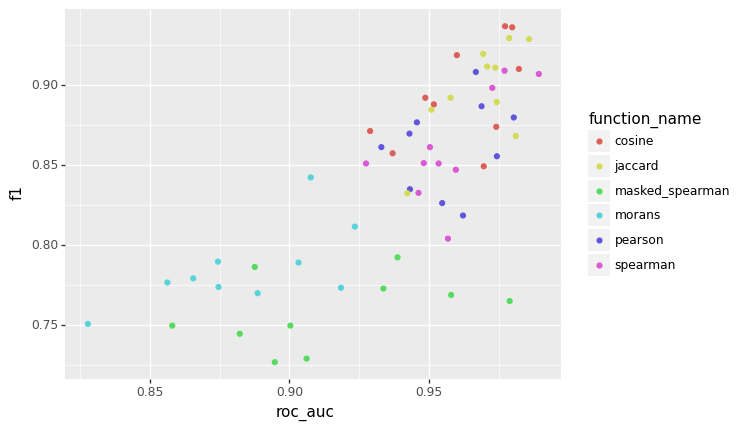

<ggplot: (8748338709871)>

In [36]:
# scatter plot of function_name, x roc_auc, y f1
p9.ggplot(performance, p9.aes(x='roc_auc', y='f1', colour='function_name')) + p9.geom_point()

mdata

In [20]:
run_rf_auc(mdata, dataset_name)

Fold: 0
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 1
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 2
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 3
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 4
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 5
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 6
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 7
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 8
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
F

In [22]:
performance = mdata.uns['performance']

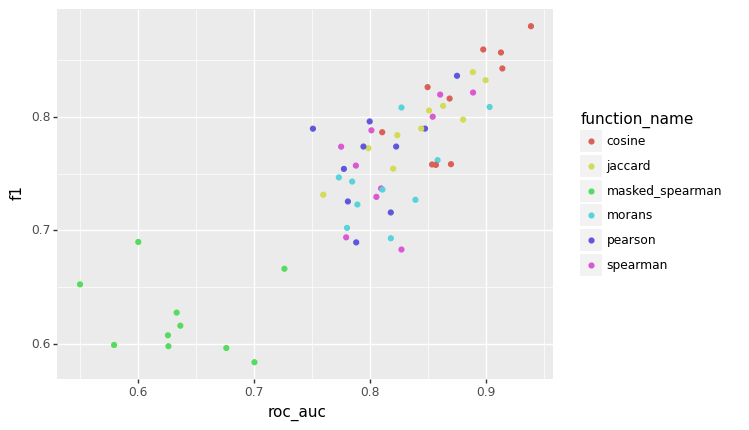

<ggplot: (8748339072934)>

In [25]:
# scatter plot of function_name, x roc_auc, y f1
p9.ggplot(performance, p9.aes(x='roc_auc', y='f1', colour='function_name')) + p9.geom_point()